In [717]:
import sqlite3
import pandas as pd
from skimpy import skim
import numpy as np
import seaborn as sns
import missingno as msno
import re
from datetime import datetime
from collections import defaultdict
import math

In [718]:
# Connexion à la base de données SQLite
connexion = sqlite3.connect('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/montre.db')

# Exécution d'une requête SQL pour récupérer des données et conversion en DataFrame
df = pd.read_sql_query('SELECT * FROM montre', connexion)

# Fermeture de la connexion
connexion.close()

# Conversion du fichier en format CSV 
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/watches_database.csv')

# Conversion en DataFrame
df = pd.read_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/watches_database.csv')

# Chargement de la BDD : 
df = df.iloc[:, 1:]

In [719]:
liste_colonnes = ['marque','modele','etat','prix','ville']

# Suppression des doublons :
def suppression_doublons(df, liste_colonnes):
    """
    Supprimme les doublons dans le DataFrame sur la base d'une liste de colonnes. 

    Args:
        df(pd.Dataframe) : Le Dataframe contenant les colonnes. 
        liste_colonne (list) : Liste des variables sur lesquelles va se baser la suppression des doublons. 
    
    Returns: 
        pd.Dataframe : DataFrame sans doublons. 
    """    
    df = df.drop_duplicates(subset=liste_colonnes, keep ='first')
    
    return df


In [720]:
df = suppression_doublons(df, liste_colonnes)

# Etude et traitement des valeurs manquantes :

id                      0
marque                387
modele               2558
mouvement             143
matiere_boitier       186
matiere_bracelet     1395
annee_prod              3
etat                   16
sexe                  369
prix                    1
reserve_de_marche    7200
diametre              705
etencheite           4178
matiere_lunette      4013
matiere_verre        2554
boucle               3097
matiere_boucle       2525
rouage               4852
ville                   1
fonctions            5922
Date_recup              0
dtype: int64
id                    0.00
marque                2.07
modele               13.71
mouvement             0.77
matiere_boitier       1.00
matiere_bracelet      7.48
annee_prod            0.02
etat                  0.09
sexe                  1.98
prix                  0.01
reserve_de_marche    38.58
diametre              3.78
etencheite           22.39
matiere_lunette      21.50
matiere_verre        13.69
boucle               16.60
matiere_b

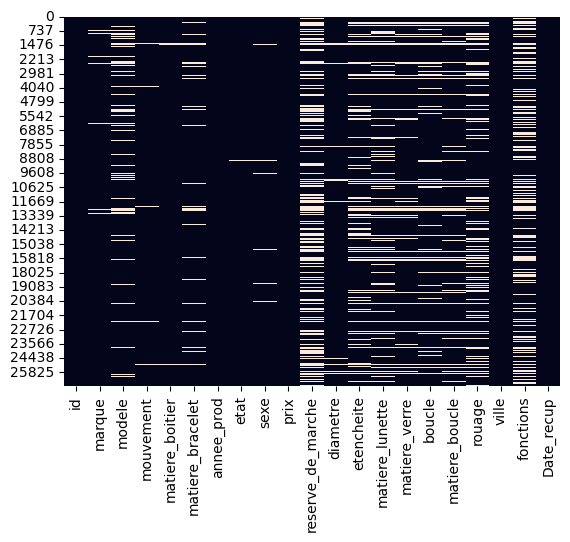

In [721]:
# Aperçu des valeurs manquantes
print(df.isnull().sum())

# Heatmap des valeurs manquantes
sns.heatmap(df.isnull(), cbar=False)

print(round(df.isnull().sum()/len(df)*100,2))


In [722]:
# Retrait des lignes pour lesquelles les valeurs des variables ne sont pas renseignées.
# Au vue de la faible proportion que représentent ces lignes, on peut simplement les retirées sans crainte de perte d'information consiérable. 
liste_colonnes = ['marque','modele','mouvement']

def suppression_lignes_vides(df, liste_colonnes): 
    """
    Fonction pour supprimer les NaN sur la base de certaines colonnes dont il est difficile de retrouver l'information. 

    Args:
        df (pd.DataFrame): Le DataFarme contenant les colonnes.
        liste_colonnes (list): Listes des colonnes sur lesquelles va se baser la suppression des colonnes.
    
    Returns: 
        pd.DataFrame : DataFrame soulagé de quelque lignes.  
    """
    df = df.dropna(subset=liste_colonnes)

    return df

In [723]:
df = suppression_lignes_vides(df, liste_colonnes)

In [724]:
# Fonction pour remplir les valeurs manquantes de certaines variables en fonction de la marque, du modèle et du mouvement
def remplissage(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]) or row[variable] == '[]':
            similar_rows = df[
                (df['marque'] == row['marque']) &
                (df['modele'] == row['modele']) &
                (df['mouvement'] == row['mouvement']) &
                df[variable].notna()
            ]
            if not similar_rows.empty:
                df.at[index, variable] = similar_rows[variable].iloc[0]
    return df

In [725]:
# Fonction pour remplir les valeurs manquantes de la variable mouvement qui sont égales à = [] en fonction de la marque, du modèle et du mouvement
def remplissage_mouvement(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]):
            similar_rows = df[
                (df['marque'] == row['marque']) &
                (df['modele'] == row['modele']) &
                (df['mouvement'] == '[]') & 
                df[variable].notna()
            ]
            if not similar_rows.empty:
                df.at[index, variable] = similar_rows[variable].iloc[0]
    return df

In [726]:
def remplissage_reserve_marche(df, variable):
    for index, row in df.iterrows():
        if pd.isna(row[variable]) or row[variable] == '[]':
            # Vérifier si row['rouage'] est une chaîne de caractères
            if isinstance(row['rouage'], str):
                similar_rows = df[
                    (row['rouage'].startswith('Quar') or row['rouage'].startswith('ETA')) &
                    df[variable].notna()
                ]
                if not similar_rows.empty:
                    df.at[index, variable] = 'Pas_de_reserve'
            else:
                # Gérer les cas où row['rouage'] n'est pas une chaîne de caractères (par exemple, NaN ou float)
                # Vous pouvez soit ignorer ces lignes, soit les gérer différemment selon vos besoins
                continue
    return df


In [727]:
df = remplissage_reserve_marche(df, 'reserve_de_marche')

In [728]:
df = remplissage(df,'matiere_boitier')
df = remplissage(df,'matiere_bracelet')
df = remplissage(df,'sexe')
df = remplissage(df, 'diametre')
df = remplissage(df,'etencheite')
df = remplissage(df, 'matiere_lunette')
df = remplissage(df, 'matiere_verre')
df = remplissage(df,'boucle')
df = remplissage(df,'matiere_boucle')
df = remplissage(df,'rouage')
df = remplissage(df, 'reserve_de_marche')


In [729]:
df = remplissage_mouvement(df, 'mouvement')

In [730]:
def suppression_lignes_vides_suite(df, liste_colonnes, colonnes_a_supp, colonne):
    """
    Fonctions pour supprimer les lignes vides sur la base de certaines colonnes dont on à toujours pas pu remplir les informations.
    Supprime également certaines colonnes initules.  

    Args:
        df (pd.DataFarme): DataFrame contenant les colonnes à traiter. 
        liste_colonnes (list): Liste des colonnes à traiter.
    
    Returns: 
        pd.DataFrame : DataFrame modifié.  
    """
    
    df = df.dropna(subset=liste_colonnes)
    df = df[df[colonne] != '[]']
    df = df.drop(columns=colonnes_a_supp)
    df = df.dropna(subset=liste_colonnes)
    
    return df
    

In [731]:
# Création d'une fonction pour la création d'une variable correspondant au nombre de complications que possède la montre
def count_functions(fonction_string):
    if pd.isna(fonction_string):
        return 0
    if 'Fonctions\n' in fonction_string:
        fonctions_part = fonction_string.split('Fonctions\n')[1]
        # Diviser par les virgules et les espaces pour obtenir les fonctions
        fonctions_list = [func.strip() for func in fonctions_part.split(',')]
        return len(fonctions_list)
    elif 'Autres\n' in fonction_string:
        fonctions_part = fonction_string.split('Autres\n')[1]
        # Diviser par les virgules et les espaces pour obtenir les fonctions
        fonctions_list = [func.strip() for func in fonctions_part.split(',')]
        return len(fonctions_list)
    else:
        return 'Non_renseignée'
    

In [732]:
df['Complications'] = df['fonctions'].apply(count_functions)

In [733]:
def remplissage_mouvement_bis(df, variable):
    for index, row in df.iterrows():
        if row[variable] == '[]':
            df.at[index, variable] = 'Quartz'
    return df

In [734]:
def remplissage_mat_verre(df, variable):
    for index, row in df.iterrows():
        if row[variable] == '[]':
            df.at[index, variable] = 'Inconnue'
    return df

In [735]:
def remplissage_reserve_marche_bis(df, variable):
    # Utiliser des opérations vectorisées pour identifier les lignes à modifier
    masque = (df[variable].isna()) & (df['mouvement'] == 'Quartz')
    
    # Appliquer la valeur 'Pas_de_reserve' aux lignes identifiées
    df.loc[masque, variable] = 'Pas_de_reserve'
    
    return df

In [736]:
df = remplissage_mouvement_bis(df, 'mouvement')

In [737]:
df = remplissage_mat_verre(df, 'matiere_verre')

In [738]:
df = remplissage_reserve_marche_bis(df, 'reserve_de_marche')

In [739]:
df = df[df['matiere_boitier'] != '[]']


In [740]:
liste_colonnes = ['rouage','etencheite','matiere_bracelet', 'etat', 'sexe', 'diametre', 'matiere_lunette',
                       'matiere_verre', 'boucle','reserve_de_marche' ]
colonnes_a_supp = ['rouage', 'fonctions','id']

colonne = 'matiere_boitier'

def suppression_lignes_vides_suite(df, liste_colonnes, colonnes_a_supp, colonne):
    """Fonctions pour supprimer les lignes vides sur la base de certaines colonnes dont on à toujours pas pu remplir les informations. 

    Args:
        df (pd.DataFarme): DataFrame contenant les colonnes à traiter. 
        liste_colonnes (list): Liste des colonnes à traiter.
    
    Returns: 
        pd.DataFrame : DataFrame modifié.  
    """
    
    df = df.dropna(subset=liste_colonnes)
    df = df.drop(columns=colonnes_a_supp)
    df = df[df[colonne] != '[]']
    
    return df

In [741]:
df = suppression_lignes_vides_suite(df, liste_colonnes, colonnes_a_supp, colonne)

# Traitement de la variable *Marque* : 

In [742]:
df['marque'] = df['marque'].astype(str)
marque = [i.replace('&', '') for i in df['marque']]
marque = [i.strip("['").strip("']")for i in marque]
marque = [i.replace(',','') for i in marque]
marque = [i.replace("''",'').replace(" ",'').replace("''",'_').replace('-','_') for i in marque]
marque = [i.upper() for i in marque]
df['marque'] = marque
df['marque'] = df['marque'].astype('category')

### Utilisation de la fonction fuzzywuzzy pour la correction des fautes d'orthographes et regrourpement des catégories similaires

In [743]:
from fuzzywuzzy import process

# Liste des catégories uniques nettoyées
categories_uniques = df['marque'].unique()

# Fonction de correspondance floue pour les catégories similaires
def fuzzy_grouping(valeur, categories_reference, seuil=80):
    correspondance, score = process.extractOne(valeur, categories_reference)
    if score >= seuil:
        return correspondance
    return valeur

# Application de la fonction de correspondance floue
df['marque'] = df['marque'].apply(fuzzy_grouping, categories_reference=categories_uniques)

In [744]:
#seuil = 50
#freq_apparition = df['marque'].value_counts()
#df['marque'] = df['marque'].apply(lambda x: x if freq_apparition[x] > seuil else 'RARE')

# Traitement de la variable *Modele* : 

In [745]:
modele = [''.join(i.split(",")[0:2]) for i in df['modele']]
modele = [i.strip("['").strip("']").replace(',','').replace(' ','').replace("''","_") for i in modele]
modele = [i.upper() for i in modele]
df['modele'] = modele
df['modele'] = df['modele'].astype('category')

In [746]:
# Liste des catégories uniques nettoyées
categories_uniques = df['modele'].unique()

# Fonction de correspondance floue pour les catégories similaires
def fuzzy_grouping(valeur, categories_reference, seuil=80):
    correspondance, score = process.extractOne(valeur, categories_reference)
    if score >= seuil:
        return correspondance
    return valeur

# Application de la fonction de correspondance floue
df['modele'] = df['modele'].apply(fuzzy_grouping, categories_reference=categories_uniques)

In [747]:
#seuil = 100
#freq_apparition = df['modele'].value_counts()
#df['modele'] = df['modele'].apply(lambda x: x if freq_apparition[x] > seuil else 'RARE')

In [748]:
#mapping = {
    #'DATEJUST_36' : 'DATEJUST',
    #'DATEJUST_41' : 'DATEJUST',
    #'DATEJUST_31' : 'DATEJUST',
    #'BLACK_BAY_FIFTY-EIGHT' : 'BLACK_BAY',
    #'OYSTER_PERPETUAL_36' : 'OYSTER_PERPETUAL',
    #'OYSTER_PERPETUAL_31': 'OYSTER_PERPETUAL',
    #'LADY-DATEJUST' : 'LADY_DATEJUST' 
#}

#df['modele'] = df['modele'].replace(mapping)

# Traitement de la variable *Mouvement* : 

In [749]:
mouvement = [i.strip("['").strip("']").replace(',','').replace(' ','') for i in df['mouvement']]
mouvement = [i.upper() for i in mouvement]
df['mouvement'] = mouvement
df['mouvement'] = df['mouvement'].astype('category')

In [750]:
mapping = {"28000''A/H": "AUTOMATIQUE",
           "REMONTAGE''AUTOMATIQUE": "AUTOMATIQUE",
           "REMONTAGE''MANUEL" : "AUTOMATIQUE"
           } 
           
           
df['mouvement'] = df['mouvement'].replace(mapping)

# Traitement de la variable *Matiere_bracelet*

In [751]:
matiere_bracelet = [i.replace('mm)','Inconnue').replace("mm",'Inconnue').replace('/',"_") for i in df['matiere_bracelet']]
matiere_bracelet =  [i.upper() for i in matiere_bracelet]
df['matiere_bracelet'] = matiere_bracelet
df['matiere_bracelet'] = df['matiere_bracelet'].astype('category')

valeurs_a_remplacer = ['BRACELET','ROSE','NOIR','JAUNE',
                       'BRUN','BLANC','VERT','GRIS','BLEU','BORDEAUX',
                       'BEIGE',"['BRACELET']","['DU', 'BRACELET']",
                       "['DU', 'BRACELET', 'BRUN']","['DU', 'BRACELET', 'BLEU']",
                       "['DU', 'BRACELET', 'NOIR']"]
df['matiere_bracelet'] = df['matiere_bracelet'].replace(valeurs_a_remplacer, "INCONNUE")

mapping = {"['ACIER']" : "ACIER",
           "D'AUTRUCHE" : "CUIR_AUTRUCHE",
           "ARGENTÉ" : "ARGENT",
           "VACHE" : "CUIR_VACHE",
           "['OR_ACIER']" : "OR_ACIER",
           "['TEXTILE']" : "TEXTILE",
           "['CUIR']" : "CUIR",
           "['CAOUTCHOUC']" : "CAOUTCHOUC",
           "['TITANE']" : "TITANE",
           "['DU', 'BRACELET', 'CAOUTCHOUC']": 'CAOUTCHOUC',
           "['DU', 'BRACELET', 'ACIER']" : "ACIER",
           "['DU', 'BRACELET', 'CUIR']" :"CUIR",
           "['DU', 'BRACELET', 'OR_ACIER']":"OR_ACIER",
           "['DU', 'BRACELET', 'TEXTILE']":"TEXTILE",
           "['DU', 'BRACELET', 'TITANE']" : "TITANE",
           "['DU', 'BRACELET', 'OR', 'JAUNE']":"OR_JAUNE",
           "['DU', 'BRACELET', 'SILICONE']" :'SILICONE',
           "['DU', 'BRACELET', 'OR', 'ROSE']":"OR_ROSE",
           "['DU', 'BRACELET', 'OR']":"OR",
           "['DU', 'BRACELET', 'MATIÈRE', 'PLASTIQUE']": "PLASTIQUE",
           "['DU', 'BRACELET', 'CÉRAMIQUE']":"CERAMIQUE",
           "['DU', 'BRACELET', 'OR', 'BLANC']":"OR_BLANC",
           "['DU', 'BRACELET', 'CUIR', 'DE', 'VACHE']":"CUIR_VACHE",
           "['DU', 'BRACELET', 'PLATINE']":"PLATINE",
           "CÉRAMIQUE":"CERAMIQUE"          
    
}
df['matiere_bracelet'] = df['matiere_bracelet'].replace(mapping)

# Traitement de la variable *Matiere_boitier* 

In [752]:
matiere_boitier = [i.strip(']').strip('[') for i in df['matiere_boitier']]
matiere_boitier = [i.replace("', '","_").replace("'",'').replace('/','_') for i in matiere_boitier]
matiere_boitier = [i.upper() for i in matiere_boitier]
df['matiere_boitier'] = matiere_boitier
df['matiere_boitier'] = df['matiere_boitier'].astype('category')

# Traitement de la variable annee_prod 

In [753]:
annee_prod = [i.strip(']').strip('[') for i in df['annee_prod']]
annee_prod = [i.strip("'").strip("',").strip("").strip("'(").strip("',").strip(")") for i in df['annee_prod']]
df['annee_prod'] = annee_prod

In [754]:
import re
import pandas as pd

# Fonction pour extraire les années (format AAAA)
def extract_year(valeur):
    # Utiliser une regex pour chercher un nombre à 4 chiffres (une année)
    match = re.search(r'\b(19|20)\d{2}\b', str(valeur))
    if match:
        return match.group(0)  # Si une année est trouvée, la retourner
    else:
        return None  # Si aucune année n'est trouvée

# Appliquer la fonction à la liste de données
annee_prod = [extract_year(valeur) for valeur in df['annee_prod']]
df['annee_prod'] = annee_prod

# Traitement de la variable Etat

In [755]:
etat = [i.replace("[", "").replace("]", "").replace("'", "").replace("\"", "").replace("(", "").replace(")", "") for i in df['etat']]
etat = [i.split(",")[0:2] for i in etat]
etat = [''.join(sous_liste).strip() for sous_liste in etat]
df['etat'] = etat
df['etat'] = df['etat'].astype('category')

In [756]:
# Dictionnaire de regroupement des modalités
regroupement_modalites = {
    'Neuf/Très bon': [
        'Très bon', 'Neuve Neuve', 'Neuf', 'Aucune trace', 'État neuf', 'dorigine/Pièces originales', 'Jamais portée'
    ],
    'Bon/Satisfaisant': [
        'Bon Traces', 'Satisfaisant Traces', 'Doccasion Bon', 'Doccasion Très', 'Doccasion Satisfaisant', 'Légères traces', 'Traces dusure', 'Doccasion :'
    ],
    'Défectueux': ['Défectueux Fortement'],
    'Incomplet': ['Incomplet Éléments', 'Doccasion Incomplet']
}

# Fonction pour obtenir la nouvelle modalité basée sur la codification minimaliste
def obtenir_nouvelle_modalite(modalite):
    for nouvelle_modalite, modalites_orig in regroupement_modalites.items():
        if modalite in modalites_orig:
            return nouvelle_modalite
    return 'Autre'  # Pour gérer les cas non couverts

# Exemple d'utilisation
modalites_simplifiees = [obtenir_nouvelle_modalite(mod) for mod in df['etat']]

In [757]:
df['etat'] = modalites_simplifiees

In [758]:
mapping = {
    'Neuf/Très bon' : 'NEUF',
    'Bon/Satisfaisant' : 'SATISFAISANT',
    'Incomplet' :'INDETERMINE',
    'Autre' :'INDETERMINE',
    'Défectueux' : 'DEFECTUEUX'
} 


df['etat'] = df['etat'].replace(mapping)

# Traitement de la variable sexe 

In [759]:
sexe = [i.upper() for i in df['sexe']]
df['sexe'] = sexe
df['sexe'] = df['sexe'].astype('category')

In [760]:
mapping = {"['HOMME/UNISEXE']":"HOMME",
            "HOMME/UNISEXE":"HOMME",
           "['MONTRE', 'HOMME/UNISEXE']":"HOMME",
           "['MONTRE', 'FEMME']":"FEMME"  
}

df['sexe'] = df['sexe'].replace(mapping)

# Traitement de la variable prix :

In [761]:
def extraire_elements_avant_euro(chaine):
    # Convertir la chaîne en liste Python
    liste = eval(chaine)
    
    # Initialiser une liste vide pour les résultats
    sous_liste = []
    
    # Vérifier si '€)' ou '€' est dans la liste
    if '€)' in liste:
        # Trouver l'index de '€)'
        index_fin = liste.index('€)')
        
        # Extraire les deux éléments précédant '€)' s'ils existent
        if index_fin >= 2:
            sous_liste = liste[index_fin-2:index_fin]
        else:
            sous_liste = liste[:index_fin]
    elif '€' in liste:
        # Trouver l'index de '€'
        index_fin = liste.index('€')
        
        # Extraire les deux éléments précédant '€' s'ils existent
        if index_fin >= 2:
            sous_liste = liste[index_fin-2:index_fin]
        else:
            sous_liste = liste[:index_fin]
    
    return sous_liste

In [762]:
df['prix'] = df['prix'].apply(extraire_elements_avant_euro)

In [763]:
prix = [''.join(sous_liste).strip() for sous_liste in df['prix']]
prix = [i.replace("(=","") for i in prix]
df['prix'] = prix
df = df[df['prix'] != '']
df['prix'] = df['prix'].astype('float')

# Traitement de la variable réserve de marche 

In [764]:
# Fonction pour extraire les éléments spéciaux
def extraire_elements_h(chaine):
    # Gérer le cas spécial 'Pas_de_reserve'
    if chaine == 'Pas_de_reserve':
        return 0
    if chaine == '[Ultra, Thin, Réserve, de, Marche]':
        return 0
    
    # Convertir la chaîne en liste Python
    liste = eval(chaine)
    
    # Vérifier si 'h' est dans la liste
    if 'h' in liste:
        # Trouver l'index de 'h'
        index_h = liste.index('h')
        
        # Extraire l'élément précédant 'h' s'il existe
        if index_h >= 1:
            return liste[index_h-1]
        else:
            return liste[:index_h]
    
    # Si aucune des conditions n'est remplie, retourner la liste entière
    return list 

In [765]:
df['reserve_de_marche'] = df['reserve_de_marche'].apply(extraire_elements_h)

In [766]:
df = df[df['reserve_de_marche'] != '<class list>']

# Traitement de la variable diametre 

In [767]:
diametre = [i.split(',')[0] for i in df['diametre']]
diametre = [i.replace(" ","") for i in diametre]
diametre = [i.replace('[',"").replace("]","").replace("'",'').replace("mm","") for i in diametre]
df['diametre'] = diametre
df['diametre'] = df['diametre'].astype('float')
diametre = [math.ceil(i) for i in df['diametre']]
df['diametre'] = diametre


# Traitement de la varaible etencheite 

In [768]:
etencheite = [i.split(',')[0] for i in df['etencheite']]
etencheite = [i.replace('[',"").replace("]","").replace("'",'').replace('Non', '0').replace('Au-delà','0') for i in etencheite]
df['etencheite'] = etencheite
df['etencheite'] = df['etencheite'].astype('float')

# Traitement de la variable matiere_lunette

In [769]:
valeurs_a_remplacer = ['rose','jaune','blanc','rouge']
df['matiere_lunette'] = df['matiere_lunette'].replace(valeurs_a_remplacer, 'Indetermine')
matiere_lunette = [i.replace("/","_").upper() for i in df['matiere_lunette']]
df['matiere_lunette'] = matiere_lunette
df['matiere_lunette'] = df['matiere_lunette'].astype('category')

In [770]:
# Fonction pour nettoyer et extraire la matière
def extract_matter(val):
    # Vérifier si la valeur est une liste sous forme de chaîne
    if isinstance(val, str) and '[' in val and ']' in val:
        # Extraire les éléments de la liste à partir de la chaîne
        elements = re.findall(r"'([^']*)'", val)
        # Chercher le dernier élément de la liste (la matière)
        return elements[-1] if elements else None
    else:
        # Si ce n'est pas une liste, retourner la valeur elle-même
        return val

In [771]:
matiere_lunette = [extract_matter(val) for val in df['matiere_lunette']]
df['matiere_lunette'] = matiere_lunette

# Traitement de la variable matiere_verre

In [772]:
matiere_verre = [i.replace("[","").replace("]","").replace("'","") for i in df['matiere_verre']]
matiere_verre = [i.upper() for i in matiere_verre]
df['matiere_verre'] = matiere_verre
df['matiere_verre'] = df['matiere_verre'].astype('category')

In [773]:
mapping = {
    'VERRE, SAPHIR' : 'SAPHIR',
    'VERRE, MINÉRAL' : 'MINÉRAL'
}

df['matiere_verre'] = df['matiere_verre'].replace(mapping)

# Traitement de la variable boucle 

In [774]:
boucle = [i.strip(",").replace("[","").replace("]","").replace("'","").replace(",","").replace(" ","_") for i in df['boucle']]
boucle = [i.upper() for i in boucle]
df['boucle'] = boucle
df['boucle'] = df['boucle'].astype('category')

# Traitement de la variable matiere_boucle

In [775]:
matiere_boucle = [i.strip(",").replace("[","").replace("]","").replace("'","").replace(",","").replace(" ","_").replace("/","_") for i in df['matiere_boucle']]
matiere_boucle = [i.upper() for i in matiere_boucle]
df['matiere_boucle'] = matiere_boucle
df['matiere_boucle'] = df['matiere_boucle'].astype('category')

In [776]:
df['matiere_boucle'] = df['matiere_boucle'].str.replace('DE_LA_LUNETTE_','').str.replace('DE_LA_BOUCLE_','').str.replace('MATIÈRE_','')

# Traitement de la variable ville 

In [777]:
pays = [i.replace('[','').replace(']','').replace("'","") for i in df['ville']]
pays = [i.split(',')[0] for i in pays]
pays = [i.upper() for i in pays]
df = df.drop(columns=['ville'])
df['pays'] = pays
df['pays'] = df['pays'].astype('category')

In [778]:
mapping = {
    'AFRIQUE': 'AFRIQUE_DU_SUD',
    'RÉPUBLIQUE' : 'RÉPUBLIQUE_TCHEQUE',
    'HONG' : 'HONG_KONG',
    'VIÊT' : 'VIETNAM',
    'PORTO' : 'PORTUGAL',
    'E.A.U.' : 'EMIRAT_ARABE_UNIS',
    'SRI': 'SRI_LANKA',
    'ARABIE' : 'ARABIE_SAOUDITE' 
}

df['pays'] = df['pays'].replace(mapping)

In [779]:
df['Complications'].astype('category')

0        1
1        1
2        1
3        1
5        0
        ..
27628    1
27649    1
27694    1
27766    1
27820    1
Name: Complications, Length: 14528, dtype: category
Categories (11, object): [0, 1, 2, 3, ..., 7, 8, 9, 'Non_renseignée']

In [780]:
df['Date_recup'] = pd.to_datetime(df['Date_recup'])

# Sauvegarde la BDD nettoyée :

In [781]:
df.to_csv('/Users/f.b/Desktop/Data_Science/Clock_industry/Scripts/Data/data_clean.csv')